In [1]:
import transformers
import os
from PIL import Image
import matplotlib.pyplot as plt

/home/whalenlex/.local/share/virtualenvs/jpdf-to-txt-x2aoK0lp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get labels and file paths
file_paths = []
train_img_path = "train_imgs/"
file_paths = sorted(os.listdir(train_img_path))

# Define a custom sorting function to handle numbers naturally
def natural_sort_key(file_name):
    return [int(part) if part.isdigit() else part for part in file_name.split('.')]

# Sort the files using the custom sorting function
file_paths= sorted(file_paths, key=natural_sort_key)

In [3]:
import pandas as pd
df = pd.read_csv('training_labels.csv')

In [4]:
df['path'] = file_paths

In [5]:
def display_img(img_path):
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

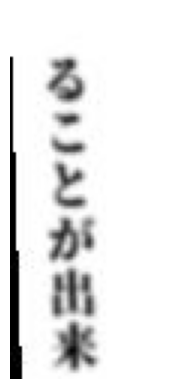

In [6]:
# example of show img
display_img('train_imgs/10.jpg')

In [7]:
def display_img_from_tensor(tens):
    # For example, if you load an image using torchvision, you might have something like:
    # your_tensor = torchvision.io.read_image('your_image_path.jpg')
    # or if you're using a pre-trained model, you might obtain a tensor from the model's output

    # Assuming 'your_tensor' is a 3D tensor (channels, height, width)
    # If it's a 4D tensor (batch_size, channels, height, width), you may need to select a specific batch element
    img_arr = tens.permute(1,2,0).detach().cpu().numpy()
    plt.imshow(img_arr)
    plt.axis('off')
    plt.show()

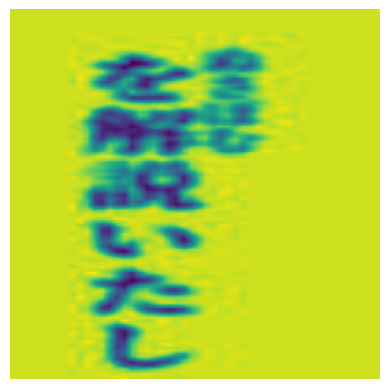

を解説いたし


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming you have a DataFrame named df with columns "path" and "labels"
# Example:
# df = pd.DataFrame({'path': ['image1.jpg', 'image2.jpg', ...], 'labels': ['label1', 'label2', ...]})

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Define a custom PyTorch dataset
class OCRDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join('train_imgs',self.dataframe.iloc[idx]['path'])
        label = self.dataframe.iloc[idx]['labels']

        # Load and preprocess the image
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        if self.transform:
            img = self.transform(img)

        return {
            'imgs':img,
            'labels':label
        }

# Define transformations (adjust as needed)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create instances of the dataset for training and validation
train_dataset = OCRDataset(train_df, transform=transform)
val_dataset = OCRDataset(val_df, transform=transform)

# Create PyTorch data loaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example: Print the first batch of the training loader
for dict_img in train_loader:
    display_img_from_tensor(dict_img['imgs'][0])
    print(dict_img['labels'][0])
    break


In [9]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-char-v2")
model = AutoModelForMaskedLM.from_pretrained("cl-tohoku/bert-base-japanese-char-v2")

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-char-v2 were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("facebook/deit-tiny-patch16-224")
model = AutoModelForImageClassification.from_pretrained("facebook/deit-tiny-patch16-224")

In [11]:
encoder_name = 'facebook/deit-tiny-patch16-224'
decoder_name = 'cl-tohoku/bert-base-japanese-char-v2'

In [12]:
from transformers import Seq2SeqTrainer

In [13]:
from transformers import AutoConfig, AutoModelForCausalLM, AutoModel, TrOCRProcessor, VisionEncoderDecoderModel, \
    AutoFeatureExtractor, AutoTokenizer, VisionEncoderDecoderConfig

In [14]:
from transformers import TrOCRProcessor

class CustomTrOCRProcessor(TrOCRProcessor):
    def __init__(self, feature_extractor, tokenizer):
        super().__init__(feature_extractor, tokenizer)

    # Override methods or properties as needed
    # For example, you might override a method that uses feature_extractor

# Use your custom processor
def get_processor(encoder_name, decoder_name):
    feature_extractor = AutoFeatureExtractor.from_pretrained(encoder_name)
    tokenizer = AutoTokenizer.from_pretrained(decoder_name)
    
    processor = CustomTrOCRProcessor(feature_extractor, tokenizer)
    
    # Now you can access and modify feature_extractor within your custom processor
    
    return processor


In [15]:
def get_model(encoder_name,decoder_name,max_length,num_decoder_layers=None):
    encoder_config = AutoConfig.from_pretrained(encoder_name)
    encoder_config.is_decoder = False
    encoder_config.add_cross_attention = False
    encoder = AutoModel.from_config(encoder_config)

    decoder_config = AutoConfig.from_pretrained(decoder_name)
    decoder_config.max_length = max_length
    decoder_config.is_decoder = True
    decoder_config.add_cross_attention = True
    decoder = AutoModelForCausalLM.from_config(decoder_config)


    if num_decoder_layers is not None:
        if decoder_config.model_type == 'bert':
            decoder.bert.encoder.layer = decoder.bert.encoder.layer[-num_decoder_layers:]
        elif decoder_config.model_type in ('roberta', 'xlm-roberta'):
            decoder.roberta.encoder.layer = decoder.roberta.encoder.layer[-num_decoder_layers:]
        else:
            raise ValueError(f'Unsupported model_type: {decoder_config.model_type}')

        decoder_config.num_hidden_layers = num_decoder_layers

    config = VisionEncoderDecoderConfig.from_encoder_decoder_configs(encoder.config, decoder.config)
    config.tie_word_embeddings = False
    model = VisionEncoderDecoderModel(encoder=encoder, decoder=decoder, config=config)

    processor = get_processor(encoder_name, decoder_name)

    # set special tokens used for creating the decoder_input_ids from the labels
    model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
    model.config.pad_token_id = processor.tokenizer.pad_token_id
    # make sure vocab size is set correctly
    model.config.vocab_size = model.config.decoder.vocab_size

    # set beam search parameters
    model.config.eos_token_id = processor.tokenizer.sep_token_id
    model.config.max_length = max_length
    model.config.early_stopping = True
    model.config.no_repeat_ngram_size = 3
    model.config.length_penalty = 2.0
    model.config.num_beams = 4

    return model, processor

In [16]:
model,processor= get_model(encoder_name,decoder_name,max_length=300,num_decoder_layers=2)

/home/whalenlex/.local/share/virtualenvs/jpdf-to-txt-x2aoK0lp/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [17]:
import numpy as np
from datasets import load_metric


class Metrics:
    def __init__(self, processor):
        self.cer_metric = load_metric("cer")
        self.processor = processor

    def compute_metrics(self, pred):
        label_ids = pred.label_ids
        pred_ids = pred.predictions
        print(label_ids.shape, pred_ids.shape)

        pred_str = self.processor.batch_decode(pred_ids, skip_special_tokens=True)
        label_ids[label_ids == -100] = self.processor.tokenizer.pad_token_id
        label_str = self.processor.batch_decode(label_ids, skip_special_tokens=True)

        pred_str = np.array([''.join(text.split()) for text in pred_str])
        label_str = np.array([''.join(text.split()) for text in label_str])

        results = {}
        try:
            results['cer'] = self.cer_metric.compute(predictions=pred_str, references=label_str)
        except Exception as e:
            print(e)
            print(pred_str)
            print(label_str)
            results['cer'] = 0
        results['accuracy'] = (pred_str == label_str).mean()

        return results

In [18]:
metrics = Metrics(processor)

/tmp/ipykernel_1423925/3923156780.py:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  self.cer_metric = load_metric("cer")


In [19]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator

In [20]:
from transformers import default_data_collator

In [21]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy='steps',
    save_strategy='steps',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    fp16_full_eval=True,
    dataloader_num_workers=16,
    output_dir='train/',
    logging_steps=10,
    save_steps=20000,
    eval_steps=20000,
    num_train_epochs=100,
    run_name='debug',
)

In [22]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=metrics.compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)

/home/whalenlex/.local/share/virtualenvs/jpdf-to-txt-x2aoK0lp/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [23]:
trainer.train()

ValueError: The batch received was empty, your model won't be able to train on it. Double-check that your training dataset contains keys expected by the model: pixel_values,decoder_input_ids,decoder_attention_mask,encoder_outputs,past_key_values,decoder_inputs_embeds,labels,use_cache,output_attentions,output_hidden_states,return_dict,kwargs,label,label_ids,labels.